# Optimization
To improve the probabilities of our Biscuit-Tester when deploying the code on a Quantum Computer, we have mulitple options. The options can be devided into two categories, soft- and hardware based improvements.

## Software optimization
Software enabled optimization is the

The here used techniques are:
- noise reduction
- Measurement Error Mitigation

## Hardware optimization

## Setup
First we have to setup the code


In [1]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, transpile, Aer, IBMQ # circuit creation and execution
from qiskit.providers.aer.noise import NoiseModel # simulate backends
from qiskit.visualization import plot_histogram # visualize results
from qiskit.quantum_info import Statevector, state_fidelity, hellinger_fidelity # statevector and metrics
from qiskit.providers.ibmq import least_busy # get least busy device
import qiskit.tools.jupyter # visualize backends
from qiskit.circuit.library.standard_gates.rx import RXGate
# from qiskit.ignis.mitigation.measurement import complete_meas_cal,CompleteMeasFitter # measurement error mitigation

import pandas as pd # handy tools for calculation
from numpy import pi
import pandas as pd
import matplotlib.pyplot as plt

# global vars
n = 3 # number of qubits
shots = 1000 # high number of shots per execution

## Own Code
This is the improved code for the simple biscuit test

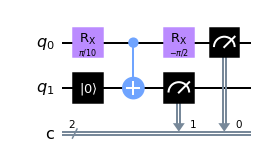

In [2]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.rx(pi/10, qreg_q[0])
circuit.reset(qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.rx(-pi/2, qreg_q[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw(output='mpl')

The code gets converted into qasm code to deploy it onto a Quantum Computer.

In [3]:
print(circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
rx(pi/10) q[0];
reset q[1];
cx q[0],q[1];
rx(-pi/2) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];



Here We simulate the probability output of the unimproved circuit.

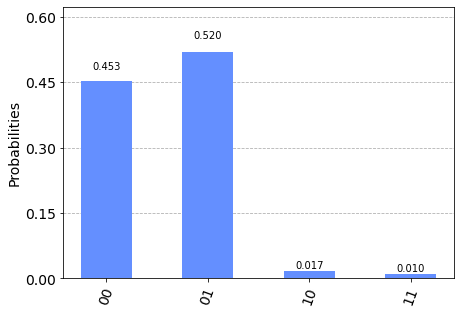

In [4]:
# Running the basic bomb tester circuit

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

## Setup for Noise optimization
## might improve , shorten code

In [5]:
expected_states = ['00', '01', '10', '11']  # target states

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [6]:
counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts() # execution on simulator
state_accuracy = get_state_accuracy(counts)
print(f"state accuracy on the simulator: {state_accuracy}")

state accuracy on the simulator: 100.0%


Importing fake Backend

In [7]:
from qiskit.test.mock import *

backends = [FakeVigo()]
backend1 = FakeVigo()

importing backend Santiago

## Noise reduction
Noise increases the more Gates we add to the circuit. Optimization is done with the qiskit transpiler function to decrease the noise at the final gate. 

With this function, the original circuit gets translated into a new circuit with the gates used by the Quantum Computer on which the program is deployed. (fake backend)

In [8]:
# compare transpiled circuits for different optimization levels on backend 1 (fake)

optimization_levels = [0,1,2,3]
for optim_level in optimization_levels:
    print(f"optimization level: {optim_level}") 
    transpiled_circuit = transpile(circuit, backend=backend1, optimization_level=optim_level)
    print(transpiled_circuit) 
    print(transpiled_circuit.qasm())
    print("optimized circuit")

optimization level: 0
global phase: π
               ┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐     »
      q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(11π/10) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               └─────────┘└────┘└────────────┘└────┘└──────────┘┌─┴─┐»
      q_1 -> 1 ────|0>──────────────────────────────────────────┤ X ├»
                                                                └───┘»
ancilla_0 -> 2 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_1 -> 3 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_2 -> 4 ──────────────────────────────────────────────────────»
                                                                     »
          c: 2/══════════════════════════════════════════════════════»
                                                                     »
«               ┌─────────┐┌────┐┌─────

Output of the transpiled Circuit as shown in the IBM Quantum Lab

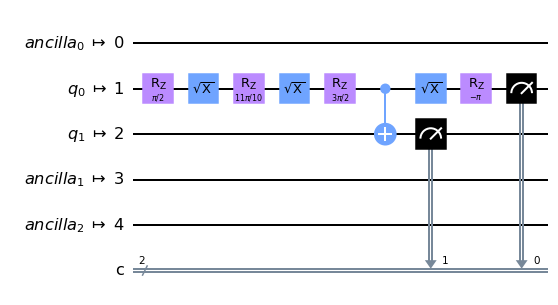

In [9]:
transpiled_circuit.draw(output='mpl')

When simulating the improved circuit, the result has clearly improved.

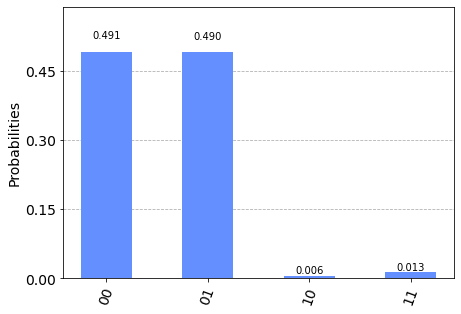

In [10]:
# Running the basic bomb tester circuit
simulator = QasmSimulator()

job = simulator.run(transpiled_circuit, shots)
result = job.result()
counts = result.get_counts(transpiled_circuit)


plot_histogram(counts)

# Measurement Error Mitigation

## Hardware optimization
Hardware based optimizationn achieves only minor improvements compared to Software based ones, but it is easier to implement.

It works by deploying the circuit on a Quantum Computer with a higher Quantum Volume(QV). QV measures several features of a Quantum Computer, among other things, the number of qubits as well as gate and measurement errors.

We tested our improved programm against the base one on two systems with the following QV: 8 and 32.

On the system with a QV of 8 the improvemnt is:

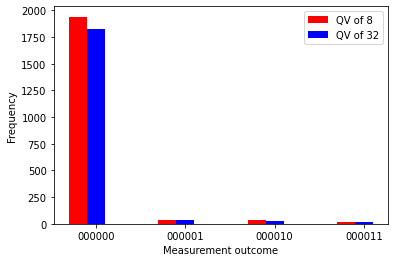

Improvement 
00 vs 10


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/00.csv' )
df2 = pd.read_csv('./Data/10.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()

On the system with a QV of 32 the improvemnt is:

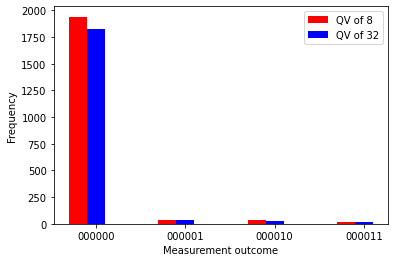

Improvement 
00 vs 10


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/00.csv' )
df2 = pd.read_csv('./Data/10.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()

## Conclusion
One Type of optimization improves the total outcome only a bit, a combination of multiple technigues increases the probability a respectable amount. The increase in the desired state was up to 10%, while simultaneously decreaing the probability in the remaining states.